In [295]:
import pandas as pd
import numpy as np 
HDFS_df_raw = pd.read_csv("./Parsing/cleanlogs/HDFS_2k.log_structured.csv")
HDFS_labels = pd.read_csv("./Parsing/cleanlogs/HDFS_2k.log_templates.csv")
HDFS_anomaly = pd.read_csv("./Parsing/rawlogs/anomaly_label.csv")

In [22]:
###
### CSV Cleaning for HDFS
###

#Create more clear EventIds: E1, E2
HDFS_labels["Clean_EventId"] = ["E" + str(i+1) for i in range(0,16)]
#Store new EventIds into Dictionary
events = dict(zip(HDFS_labels.EventId,HDFS_labels.Clean_EventId))
#Rename EventIds to E1,E2 ...
HDFS_df_raw.EventId = HDFS_df_raw.EventId.map(events)
#Create new CSV file HDFS_2k.log_structured_clean.csv
HDFS_df_raw.to_csv("./Parsing/cleanlogs/HDFS_2k.log_structured_clean.csv",sep=",",index=False)

In [ ]:
###
### Create dictionary for HDFS BlockId : Label
###
anomaly_labels = HDFS_anomaly.set_index("BlockId")["Label"].to_dict()

In [177]:
from ast import literal_eval #For keeping ParameterList as List when reading in CSV 
HDFS_clean = pd.read_csv("./Parsing/cleanlogs/HDFS_2k.log_structured_clean.csv",converters={'ParameterList': literal_eval})

In [257]:
###
### Extract blk_id into column blk_id
###

import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

def extract_blk_id(x): #Inidivudal entries inside ParameterList
    ###
    ###Check if entry is a blk_id, return True if value is a blk_id 
    ###
    ###Input: x, str
    ###Output: boolean
    
    if "blk" in x:
        return True

def extract_label(x): #Individual Entries inside blk_id
    ###
    ###Determine if given list of bulk_ids are normal, anomaly or not specified, return str. 
    ###In the case of multiple bulk_ids, if 1 blk_id corresponds to an Anomaly - will be classified as Anomaly. 
    ###If the blk_id is not in our dictionary of labels - will be classified as Unavailable.
    ###
    ###Input: x, list of blk_ids
    ###Output: label, str - either Normal, Anomaly or Unavailable
    
    for blk_id in x: #Go through list of blk_ids
        if blk_id in anomaly_labels.keys(): #Check if the id is in out list of labels
            
            if anomaly_labels[blk_id] == "Anomaly": #Find any Anomalies
                return "Anomaly" 
            else:
                return "Normal"
            
        else: #id does not exist in our dictionary (i.e. do not know label)
            return "Unavailable"
    

#Create blk_id column
count = 0
HDFS_clean["blk_id"] = "" #Initialize new column
for params in HDFS_clean.ParameterList:
    if params == []: #If the list is empty - when the IPLOM parser failed (on 3 occaisions) @ line 1438,1767,1900
        HDFS_clean["blk_id"][count] = [blkid for blkid in HDFS_clean["Content"][count].split() if extract_blk_id(blkid)] #Need to go to Content to get blk_ida
    else:
        HDFS_clean["blk_id"][count] = [blkid for blkid in params if extract_blk_id(blkid)] #Extract blk_id
    count += 1

#Create label column
HDFS_clean["label"] = [extract_label(blkid) for blkid in HDFS_clean.blk_id] #Initialize new column

#Export to CSV
HDFS_clean.to_csv("./Parsing/cleanlogs/HDFS_labelled.csv",sep=",",index=False)

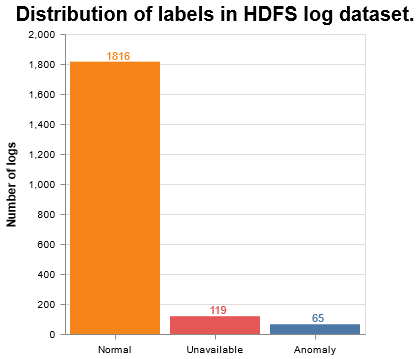

In [255]:
#Chart of Anomaly Distribution 
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')
bars = alt.Chart(HDFS_clean).mark_bar().encode(
    alt.X("label",sort="-y", axis=alt.Axis(title= None,labelAngle=0)),
    alt.Y("count()",axis=alt.Axis(title="Number of logs")),
    alt.Fill("label",legend=None)
)

text = bars.mark_text(
    baseline='bottom',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='count()'
)

(bars+text).properties(width=300,height=300,title = "Distribution of labels in HDFS log dataset. ").configure_title(fontSize=20, align="left").configure_axis(labelPadding=5, titleFontSize=12, titlePadding = 10)

In [309]:
###
### Mimic Read in, load, split, transform
### Just need to modify dataloader.py code
###
import regex as re
from sklearn.utils import shuffle
from collections import OrderedDict

#1) Read in Structured Log (with Labels)
struct_log = pd.read_csv("./Parsing/cleanlogs/HDFS_labelled.csv",converters={'blk_id': literal_eval})
int_struct_log=struct_log[["EventId","blk_id","label"]] #Subset struct_log with only columns of interest EventId, blk_id and label
int_struct_log = int_struct_log.explode("blk_id") #Each blk_id is on it's own row

#2) Load
#Want to group events by blk_id - in our case: blk_ids are unique in our dataset (1 blk id = 1 event)
#Set up un-labelled data
data_dict = OrderedDict() #Create empty dictionary
for idx,row in int_struct_log.iterrows(): #For each row in int_struct_log 
    if not row["blk_id"] in data_dict: #Check if blk_id exists already
        data_dict[row["blk_id"]] = [] 
    data_dict[row["blk_id"]].append(row['EventId']) #Add corresponding EventId to blk_id
data_df = pd.DataFrame(list(data_dict.items()), columns=['BlockId', 'EventSequence']) #Convert data_dict into data_frame
x_data = data_df['EventSequence'].values 

#3) Split up: Training:Validation:Testing
def _split_data(x_data, y_data=None, train_ratio=0, split_type='uniform'):
    if split_type == 'uniform' and y_data is not None:
        pos_idx = y_data > 0
        x_pos = x_data[pos_idx]
        y_pos = y_data[pos_idx]
        x_neg = x_data[~pos_idx]
        y_neg = y_data[~pos_idx]
        train_pos = int(train_ratio * x_pos.shape[0])
        train_neg = int(train_ratio * x_neg.shape[0])
        x_train = np.hstack([x_pos[0:train_pos], x_neg[0:train_neg]])
        y_train = np.hstack([y_pos[0:train_pos], y_neg[0:train_neg]])
        x_test = np.hstack([x_pos[train_pos:], x_neg[train_neg:]])
        y_test = np.hstack([y_pos[train_pos:], y_neg[train_neg:]])
    elif split_type == 'sequential':
        num_train = int(train_ratio * x_data.shape[0])
        x_train = x_data[0:num_train]
        x_test = x_data[num_train:]
        if y_data is None:
            y_train = None
            y_test = None
        else:
            y_train = y_data[0:num_train]
            y_test = y_data[num_train:]
    # Random shuffle
    indexes = shuffle(np.arange(x_train.shape[0]))
    x_train = x_train[indexes]
    if y_train is not None:
        y_train = y_train[indexes]
    return (x_train, y_train), (x_test, y_test)

In [311]:
(x1, y1), (x2, y2) = _split_data(x_data,train_ratio = 0.5, split_type="sequential")

In [319]:
len(x1)+len(x2)

2267

In [320]:
len(x_data)

2267